# Implémentation d'un VAE

Dans ce notebook, nous allons implémenter un VAE pour la génération d'images sur le dataset MNIST.   
Le notebook commence par une implémentation d'une Autoencodeur classique pour montrer qu'une architecture d'AE classique ne permet pas de générer des éléments nouveaux.

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

/opt/homebrew/anaconda3/envs/dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

Commençons par charger notre dataset MNIST : 

In [3]:
transform=T.ToTensor() # Pour convertir les éléments en tensor torch directement
dataset = datasets.MNIST(root='./../data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST(root='./../data', train=False,transform=transform)

print("taille du dataset d'entrainement : ",len(dataset))
print("taille d'une image : ",dataset[0][0].numpy().shape) 

train_dataset, validation_dataset=torch.utils.data.random_split(dataset, [0.8,0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader= DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

taille du dataset d'entrainement :  60000
taille d'une image :  (1, 28, 28)


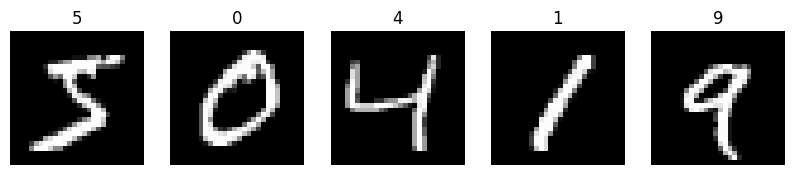

In [7]:
# Visualisons quelques images
plt.figure(figsize=(10, 10))
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(dataset[i][0].squeeze(), cmap='gray')
  plt.axis('off')
  plt.title(dataset[i][1])

## Autoencodeur sur MNIST

Construisons l'architecture de notre autoencodeur : 

In [30]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # -> [16, 14, 14]
            nn.ReLU(),
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # -> [8, 7, 7]
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, stride=2, padding=1)   # -> [8, 4, 4]
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 8, 3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
dummy_input = torch.randn(1, 1, 28, 28) 
model = AE()
output = model(dummy_input)
print(output.shape)

torch.Size([1, 1, 28, 28])


Définissons nos hyperparamètres d'entraînement : 

In [31]:
epochs = 10
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Passons à l'entraînement du modèle :

In [32]:
for epoch in range(epochs): 
    for img,_ in train_loader:
        optimizer.zero_grad()
        recon = model(img)
        loss = criterion(recon, img)
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, epochs, loss.item()))

epoch [1/10], loss:0.0087
epoch [2/10], loss:0.0068
epoch [3/10], loss:0.0057
epoch [4/10], loss:0.0065
epoch [5/10], loss:0.0054
epoch [6/10], loss:0.0057
epoch [7/10], loss:0.0057
epoch [8/10], loss:0.0053
epoch [9/10], loss:0.0050
epoch [10/10], loss:0.0053


Vérifions le comportement du modèle sur les données de test :

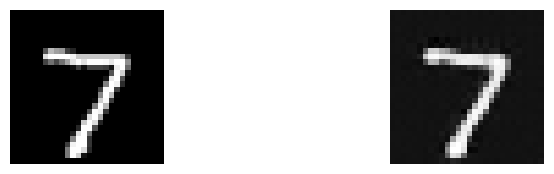

In [33]:
for data in test_loader:
    img, _ = data
    recon = model(img)
    break
plt.figure(figsize=(9, 2))
plt.gray()
plt.subplot(1, 2, 1)
plt.imshow(img[0].detach().numpy().squeeze())
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(recon[0].detach().numpy().squeeze())
plt.axis('off')
plt.show()

On va maintenant visualiser l'espace latent et la répartition de nos 10 classes dans cet espace.

In [34]:
# On commence par extraire les représentations latentes des données de test
latents = []
labels = []

with torch.no_grad():
    for data, target in test_loader:
        latent = model.encoder(data)
        latents.append(latent)
        labels.append(target)

latents = torch.cat(latents)
labels = torch.cat(labels)

On utilise la méthode [T-SNE](https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a) pour extraire des répresentations en 2D permettant de visualiser les données.

In [35]:
from sklearn.manifold import TSNE

latents_flat = latents.view(latents.size(0), -1)
tsne = TSNE(n_components=2, random_state=0)
latent_2d = tsne.fit_transform(latents_flat)

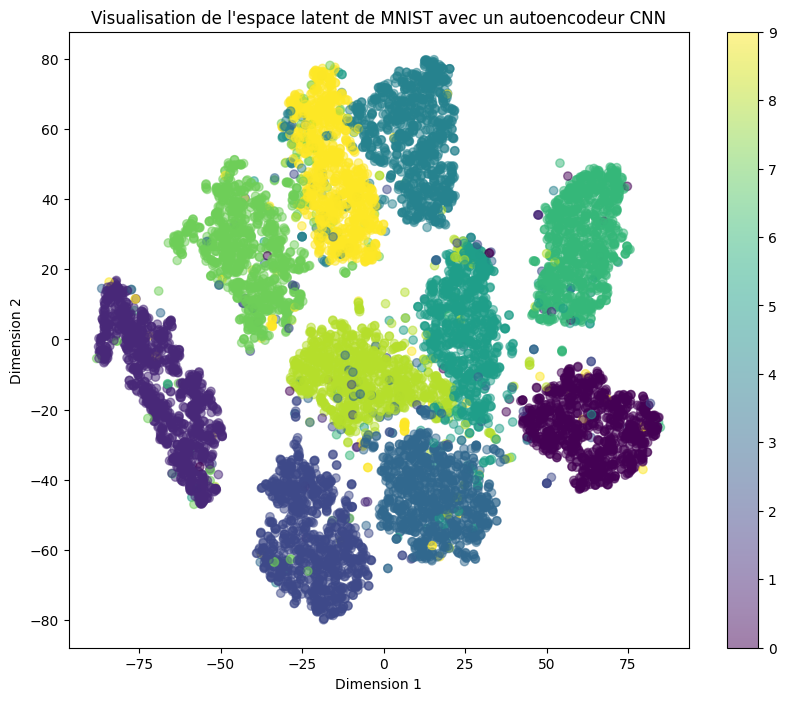

In [36]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('Visualisation de l\'espace latent de MNIST avec un autoencodeur CNN')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

Comme on pouvait s'y attendre, il y a bien une séparation entre les classes dans l'espace latent. Par contre, il y a également beaucoup d'espaces vides si bien que l'on peut difficilement sample un point quelconque de l'espace latent et esperer générer une donnée réelle cohérente.

On va regarder ce que l'on obtient si l'on génére une image à partir d'un point aléatoire de l'espace latent.

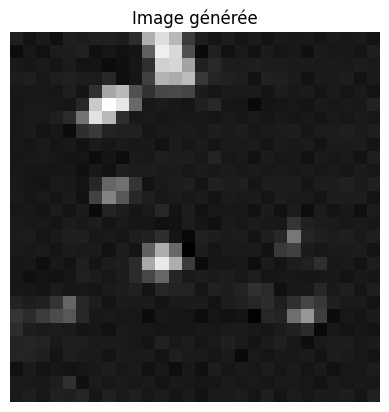

In [41]:
latent_dim = (8, 4, 4)
sampled_latent = torch.randn(latent_dim).unsqueeze(0)

# On générer l'image avec le décodeur
with torch.no_grad():
    generated_image = model.decoder(sampled_latent)

generated_image = generated_image.squeeze().numpy()  # Supprimer la dimension batch et convertir en numpy
generated_image = (generated_image + 1) / 2  # Dénormaliser l'image (car Tanh est utilisé)
plt.imshow(generated_image, cmap='gray')
plt.title("Image générée")
plt.axis('off')
plt.show()

Comme on s'y attendait, cela ne génére rien de cohérent. 

## Variational Autoencoder

Maintenant, reprenons la même architecture (plus ou moins) mais avec l'architecture VAE pour voir si l'on est capable de générer des données. 

In [159]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encodeur
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # -> [16, 14, 14]
            nn.ReLU(),
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # -> [8, 7, 7]
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, stride=2, padding=1)   # -> [8, 4, 4]
        )
        self.fc_mu = nn.Linear(8*4*4, 256)
        self.fc_logvar = nn.Linear(8*4*4, 256)
        
        # Décodeur
        self.decoder_fc = nn.Sequential(
            nn.Linear(256, 8*4*4),
            nn.ReLU()
        )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(8, 8, 3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )
    
    def encode(self, x):
        h = self.encoder_conv(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(h.size(0), 8, 4, 4)
        return self.decoder_conv(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar
    
dummy_input = torch.randn(1, 1, 28, 28)
model = VAE()
output,mu,sigma = model(dummy_input) #, mu, logvar
print(output.shape, mu.shape, sigma.shape)

torch.Size([1, 1, 28, 28]) torch.Size([1, 256]) torch.Size([1, 256])


In [160]:
epochs = 10
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
beta=0

In [161]:
for epoch in range(epochs): 
    for img,_ in train_loader:
        optimizer.zero_grad()
        recon, mu, sigma= model(img) 
        loss_recons = criterion(recon, img)
        kl_div = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
        loss =loss_recons + 0.0001*kl_div
        loss.backward()
        optimizer.step()
    beta = min(1, epoch / 10) # beta annealing 1->10 epochs
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, epochs, loss.item()))

epoch [1/10], loss:0.0290
epoch [2/10], loss:0.0204
epoch [3/10], loss:0.0190
epoch [4/10], loss:0.0161
epoch [5/10], loss:0.0152
epoch [6/10], loss:0.0145
epoch [7/10], loss:0.0137
epoch [8/10], loss:0.0139
epoch [9/10], loss:0.0133
epoch [10/10], loss:0.0128


In [162]:
latents = []
labels = []

with torch.no_grad():
    for data, target in test_loader:
        mu, logvar = model.encode(data)
        latents.append(mu)  # Utiliser mu pour représenter les points dans l'espace latent
        labels.append(target)

latents = torch.cat(latents)
labels = torch.cat(labels)

In [163]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
latent_2d = tsne.fit_transform(latents)

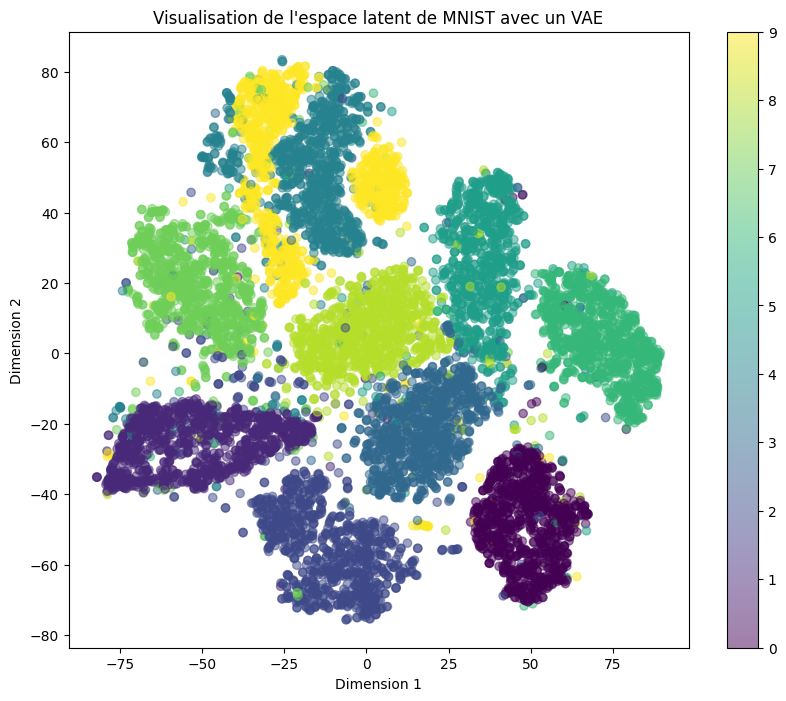

In [164]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('Visualisation de l\'espace latent de MNIST avec un VAE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

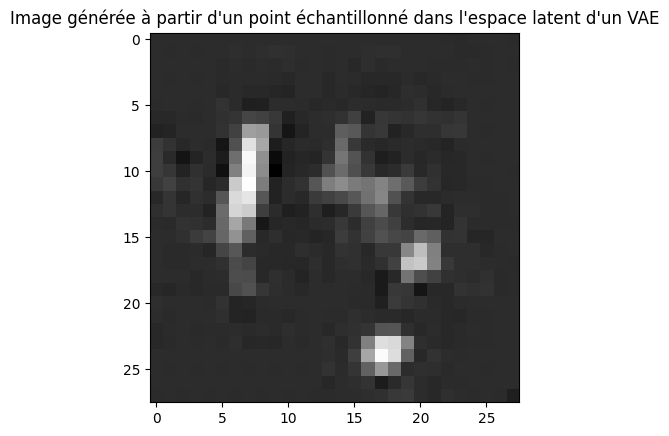

In [165]:
# Echantillonner un point dans l'espace latent
latent_dim = 256
sampled_latent = torch.randn(1, latent_dim)  # Générer un échantillon aléatoire

# Générer une image à partir du point échantillonné
with torch.no_grad():
    generated_image = model.decode(sampled_latent)

# Visualiser l'image générée
generated_image = generated_image.squeeze().numpy()  # Supprimer la dimension batch et convertir en numpy
generated_image = (generated_image + 1) / 2  # Dénormaliser l'image (car Tanh est utilisé)
plt.imshow(generated_image, cmap='gray')
plt.title("Image générée à partir d'un point échantillonné dans l'espace latent d'un VAE")
plt.show()